In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

https://www.journals.uchicago.edu/doi/abs/10.1086/260062

## Brownian Motion

The arithmetic Brownian motion is a type of stochastic process that models the random movement of financial asset prices over time.

Generating multiple paths of arithmetic Brownian motion through Monte Carlo simulations helps in visualizing how asset prices can evolve under random fluctuations. 

Euler's method is a fundamental numerical procedure for solving ordinary differential equations (ODEs) with a given initial value.
Consider an ODE of the form:

$ \frac{dy}{dt} = f(t, y(t)), \quad y(t_0) = y_0 $

where $y(t)$ is the unknown function to be solved for, $t$ is the independent variable, $y_0$ is the initial condition at time $t_0$, and $f(t, y(t))$ is a function that provides the derivative of $y(t)$ at any point $t$.

Euler's method approximates the solution by discretizing the time domain into small steps of size $dt$ and then linearly approximating the slope of the solution curve at each step. The value of $y(t)$ at the next time step is estimated using the formula:

$ y_{n+1} = y_n + f(t_n, y_n) \cdot dt $

where $y_n$ is the approximation of $y(t_n)$, and $t_{n+1} = t_n + dt$.

In the context of simulating Brownian Motion or Geometric Brownian Motion (GBM), which is commonly used in financial mathematics for modeling stock prices, Euler's method can be adapted to simulate the stochastic differential equations (SDEs) that describe these processes.

For Brownian Motion, the SDE can be simplified as:

$ dX_t = \mu dt + \sigma dW_t $

where $dX_t$ represents the change in the process $X$ over an infinitesimally small time interval $dt$, $\mu$ is the drift term, $\sigma$ is the volatility term, and $dW_t$ represents the increment of a Wiener process (or Brownian motion), which is normally distributed with mean 0 and variance $dt$.

Using Euler's method, the discrete approximation of this SDE over a time step $dt$ can be expressed as:

$ X_{t+dt} = X_t + \mu dt + \sigma \sqrt{dt} Z $

where $Z$ is a random draw from a standard normal distribution $(N(0,1))$ to simulate the random shock from the Wiener process.

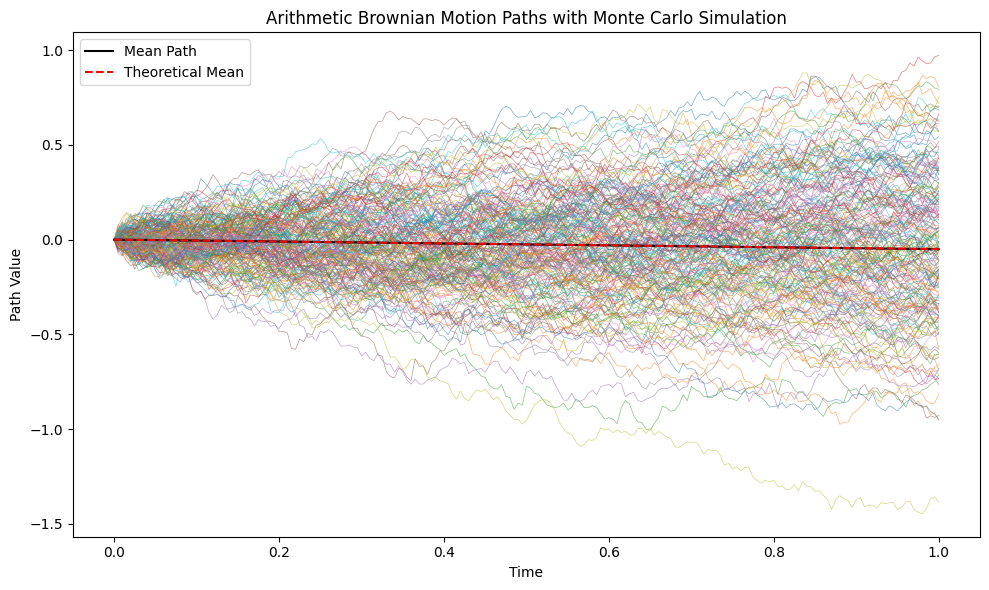

In [2]:
# Set the number of paths to simulate
npaths = 200000
# Total time for simulation (1 year)
T = 1
# Number of time steps within the year (daily steps)
nsteps = 200
# Time increment per step
dt = T / nsteps
# Drift coefficient of the Brownian motion (mean return)
mu = -0.05
# Volatility coefficient (standard deviation of returns)
sigma = 0.4
# Time grid for simulation
grid = np.linspace(0, T, nsteps + 1)

# Compute the increments of Brownian Motion using Euler's method
# Note: We scale the normal random numbers by sqrt(dt) according to the properties of Brownian Motion
dX = mu * dt + sigma * np.random.randn(npaths, nsteps) * np.sqrt(dt)

# Prepend zeros for the initial condition (stock price at time 0)
zeros = np.zeros((npaths, 1))
X = np.hstack((zeros, dX))

# Accumulate the increments to get the path
XX = np.cumsum(X, axis=1)

# Plotting
plt.figure(figsize=(10, 6))  
# Plot a subset of paths to avoid overloading the plot
for i in range(0, len(XX), 1000):
    plt.plot(grid, XX[i], linewidth=0.5, alpha=0.6)  # Reduced line width and added transparency

# Plot the mean of all paths
plt.plot(grid, np.mean(XX, axis=0), 'k', label='Mean Path', linewidth=1.5)

# Plot the theoretical mean path: mu*t
plt.plot(grid, mu * grid, 'r--', label='Theoretical Mean', linewidth=1.5)

plt.title('Arithmetic Brownian Motion Paths with Monte Carlo Simulation')
plt.xlabel('Time')
plt.ylabel('Path Value')
plt.legend()
plt.tight_layout()
plt.show()


By plotting the PDF of the simulated paths at different times, you can observe how the distribution of possible outcomes changes.

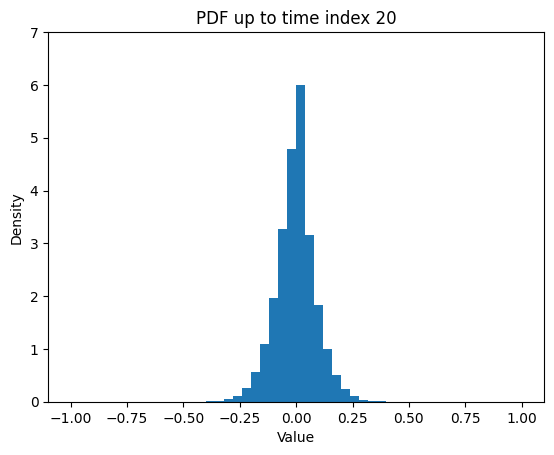

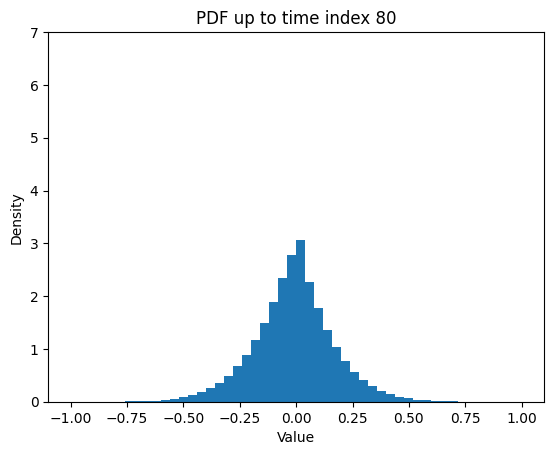

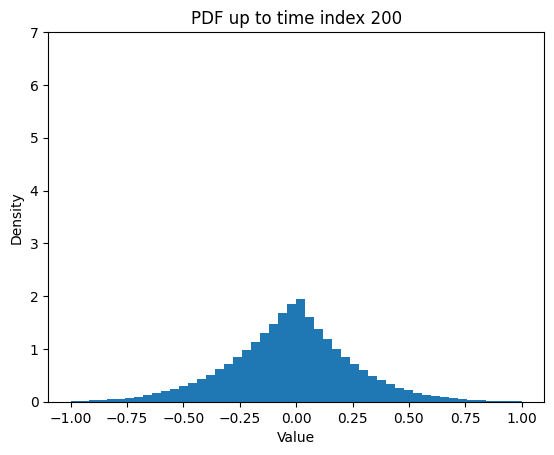

In [3]:
def plot_pdf_at_different_times(data, time_indices, fig_nums, bins=50, density_range=[-1, 1], ylim=[0, 7]):
    """
    Plot the probability density function of the data at specified time indices.

    Parameters:
    - data: The simulated paths of the arithmetic Brownian motion.
    - time_indices: A list of integers indicating the time steps at which to plot the PDF.
    - fig_nums: A list of figure numbers for the plots.
    - bins: Number of bins for the histogram.
    - density_range: The range over which to normalize the histogram.
    - ylim: Y-axis limits for the plots.
    """
    for time_idx, fig_num in zip(time_indices, fig_nums):
        plt.figure(fig_num)
        # Flatten the array up to the specified time_idx, then plot the histogram
        flat_data = data[:, :time_idx].flatten()
        plt.hist(flat_data, bins=bins, density=True, range=density_range)
        ax = plt.gca()
        ax.set_ylim(ylim)
        plt.title(f'PDF up to time index {time_idx}')
        plt.xlabel('Value')
        plt.ylabel('Density')

# Define time indices where you want to examine the PDF
time_indices = [20, 80, nsteps]  # Example time steps
fig_nums = [1, 2, 3]  # Corresponding figure numbers

# Call the function to plot PDFs
plot_pdf_at_different_times(XX, time_indices, fig_nums)

## Geometric Brownian Motion

GBM differs from arithmetic Brownian motion in that it assumes a log-normal distribution of prices, which implies that the prices cannot become negative and tend to follow a proportional growth pattern. This characteristic makes GBM more suitable for modeling stock prices than arithmetic Brownian motion.

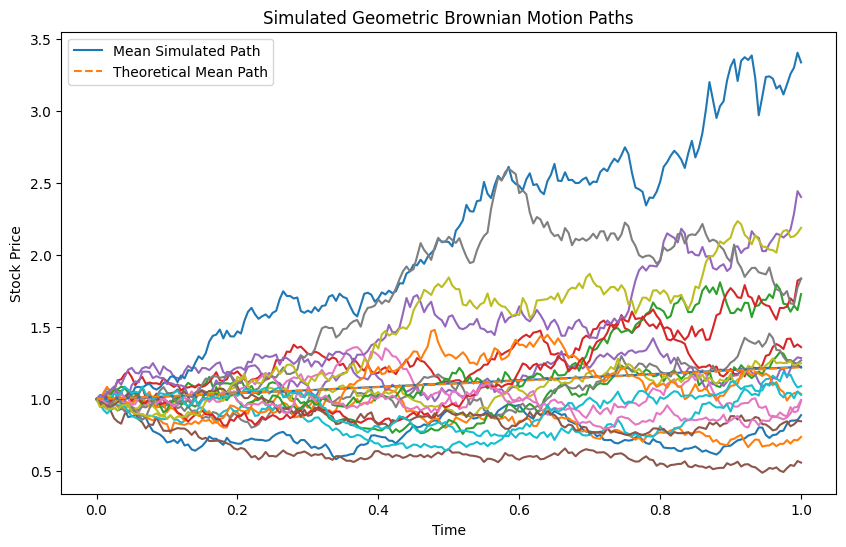

In [4]:
# Number of paths to simulate
npaths = 20000
# Total simulation time (1 year)
T = 1
# Initial stock price
S_0 = 1
# Number of steps (daily observations)
nsteps = 200
# Time increment per step
dt = T / nsteps
# Drift coefficient of the stock
mu = 0.2
# Volatility of the stock
sigma = 0.4
# Time grid for plotting
grid = np.arange(0, T + dt, dt)

# Computing the increments using Euler's method for GBM
# Note the correction term -0.5*sigma**2 to account for the drift bias in log space
dS = (mu - 0.5 * sigma ** 2) * dt + sigma * np.random.randn(npaths, nsteps) * (dt ** 0.5)

# Prepending zeros for the initial condition
zeros = np.zeros((npaths, 1))
X = np.hstack((zeros, dS))

# Cumulative sum to get the log of price relative changes
XX = np.cumsum(X, axis=1)

# Converting log-relative changes to actual stock prices
S = S_0 * np.exp(XX)

# Plotting a subset of simulated paths
plt.figure(figsize=(10, 6))  
for i in range(0, len(S), 1000):
    plt.plot(grid, S[i])
    
# Plotting the mean of the simulated paths
plt.plot(grid, np.mean(S, axis=0), label='Mean Simulated Path')

# Plotting the theoretical mean path using GBM's expected value
plt.plot(grid, np.exp(mu * grid), label='Theoretical Mean Path', linestyle='--')

plt.legend()
plt.title('Simulated Geometric Brownian Motion Paths')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

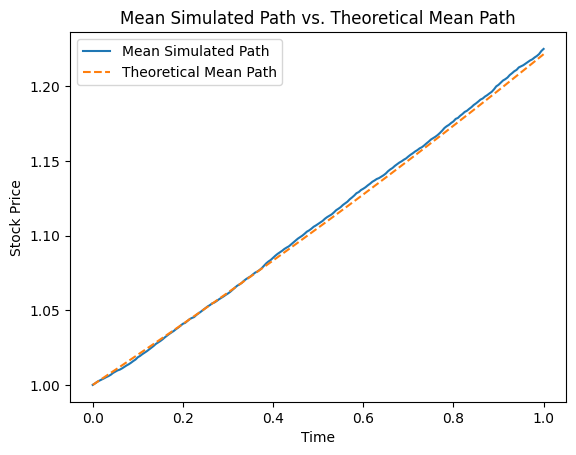

In [5]:
# Plotting the mean of the simulated paths against the theoretical mean path
plt.figure()
plt.plot(grid, np.mean(S, axis=0), label='Mean Simulated Path')
plt.plot(grid, np.exp(mu * grid), label='Theoretical Mean Path', linestyle='--')

plt.legend()
plt.title('Mean Simulated Path vs. Theoretical Mean Path')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

## Analytical Solution

In the following implementation we assume $t_0=0$:

In [6]:
# Black-Scholes formula for call and put options
def black_scholes(S, K, r, T, v, option_type='C'):
    d1 = (np.log(S / K) + (r + 0.5 * v ** 2) * T) / (v * np.sqrt(T))
    d2 = d1 - v * np.sqrt(T)
    if option_type == 'C':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'P':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price

This function calculates the price of a call or put option using the Black-Scholes formula, given the volatility $v$ ($\sigma$ in the original formula), the risk-free interest rate $r$, the current price of the underlying asset $S$, the strike price $K$, and the exercise date $T$.

In [7]:
# Configuration
flag = 'C'  # 'C' for call, 'P' for put option
K = 115  # Strike price of option
r = 0.05  # Interest rate
v = 0.5  # Volatility

# Creating grid
S, t = np.meshgrid(np.linspace(75, 130, 100), np.linspace(0, 1, 100))
# Price of underlying; Time to maturity (measured in years)

Here we define the initial variables and parameters for the model.

In [8]:
# Calculating option price for calls and puts over the grid
Vc = black_scholes(S, K, r, t, v, option_type='C')
Vp = black_scholes(S, K, r, t, v, option_type='P')

/var/folders/h9/ccpmv6014r170zs5rfn5dlgw0000gn/T/ipykernel_32709/2650169209.py:3: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * v ** 2) * T) / (v * np.sqrt(T))
/var/folders/h9/ccpmv6014r170zs5rfn5dlgw0000gn/T/ipykernel_32709/2650169209.py:3: RuntimeWarning: invalid value encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * v ** 2) * T) / (v * np.sqrt(T))


The price of the option is calculated for every combination of $S$ (price of the underlying asset) and $T$ (exercise date) in the grid, for call or put options depending on the value of the flag.

#### MATLAB Code

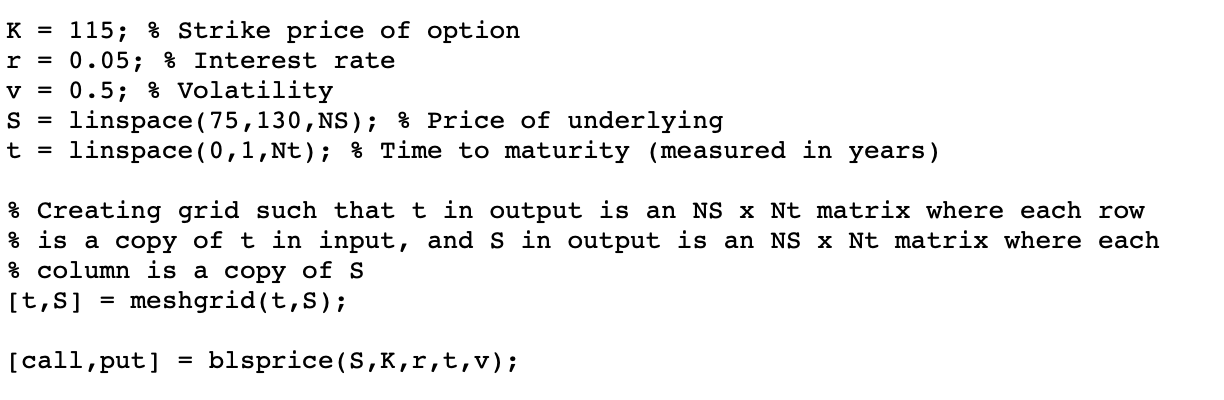

In [9]:
Image("/Users/sabrina.aufiero/Desktop/COMP0050 Machine Learning with Applications in Finance/Week 6_NN/MatLab.png", width=800)

We have analytically generated option price data using the Black-Scholes formula. In MATLAB, this can be conveniently done using the built-in blsprice function. However, in Python, we needed to manually implement this functionality.

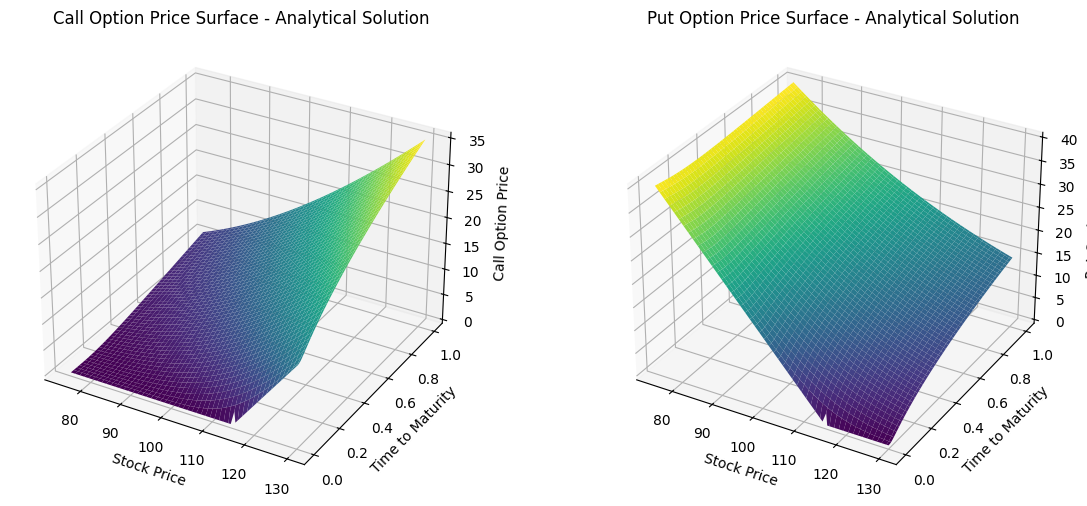

In [10]:
# Plotting surface for call option prices
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(S, t, Vc, cmap='viridis')
#fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
ax1.set_xlabel('Stock Price')
ax1.set_ylabel('Time to Maturity')
ax1.set_zlabel('Call Option Price')
ax1.set_title('Call Option Price Surface - Analytical Solution')

# Plotting surface for put option prices
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(S, t, Vp, cmap='viridis')
#fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
ax2.set_xlabel('Stock Price')
ax2.set_ylabel('Time to Maturity')
ax2.set_zlabel('Put Option Price')
ax2.set_title('Put Option Price Surface - Analytical Solution')

plt.show()

## Neural Networks

In [11]:
# Generating dataset
np.random.seed(42)  # For reproducibility
S = np.linspace(50, 150, 1000)  # Stock price
T = np.linspace(0.1, 2, 1000)  # Time to maturity
K = 100  # Strike price (constant in this example)
r = 0.05  # Risk-free rate (constant)
v = 0.2  # Volatility (constant)

# Compute option prices
prices = black_scholes(S, K, r, T, v, option_type='C')

# Preparing the input and target data
X = np.vstack((S, T)).T  # Inputs are stock prices and times to maturity
y = prices  # Target is the option price

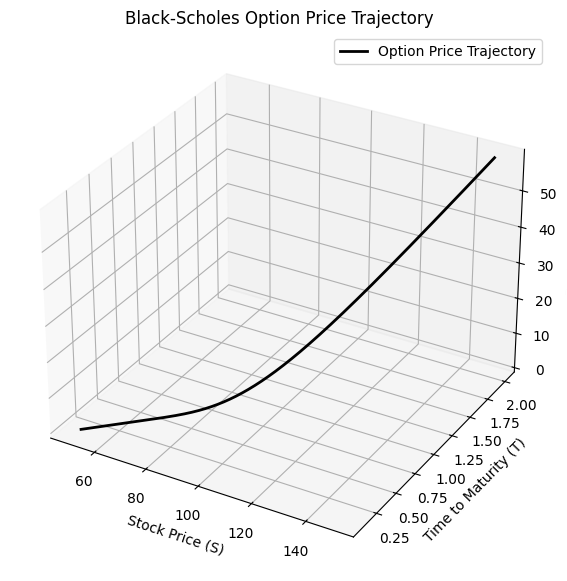

In [20]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(S, T, prices, label='Option Price Trajectory', color='black', lw=2)

ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Option Price')
ax.set_title('Black-Scholes Option Price Trajectory')

ax.legend()

plt.show()

#### Supervised Learning:

You have labeled data (the known option prices for given stock prices and times to maturity) that you use to train your model. 

The model then learns to predict the option prices (the target variable) based on the input features. 

There are different types of neural network architectures such as feedforward neural networks, convolutional neural networks, recurrent neural networks, LSTM, Transformers, and many more.

#### Multi-layer Perceptron Regressor (MLPRegressor): 

MLPRegressor stands for Multi-Layer Perceptron Regressor, and it is a type of artificial neural network used for regression tasks within the scikit-learn library in Python. It is used to model and predict continuous target values, as opposed to categorical labels.

It provides a high degree of accuracy and can handle complex, non-linear datasets. MLPRegressor is an artificial neural network model that uses backpropagation to adjust the weights between neurons in order to improve prediction accuracy. MLPRegressor implements a Multi-Layer Perceptron (MLP) algorithm for training and testing data sets using backpropagation and stochastic gradient descent methods. It includes several parameters that can be used to fine-tune the model’s performance including number of hidden layers, activation functions, solvers (for optimization), etc.  It is an efficient method for solving regression problems as it can learn complex non-linear relationships between input and output variables.

One of the main advantages of using MLPRegressor over other regression algorithms is its ability to handle data with large numbers of features or inputs. While other regression models may struggle with datasets containing hundreds or thousands of features, MLPRegressor can quickly learn the patterns and provide accurate predictions. This makes it ideal for applications such as predicting stock prices, sales figures and customer satisfaction ratings.

Another major limitation of MLPRegressor is its propensity for overfitting. Since this type of algorithm works by building complex nonlinear relationships between inputs and outputs, it can be prone to memorizing the training data which leads to poor generalization on unseen data.

In [15]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Defining the neural network model
model = MLPRegressor(hidden_layer_sizes=(100, 60), activation='relu', random_state=42, max_iter=1000)

- hidden_layer_sizes: This parameter allows you to set the number of layers and the number of nodes in each layer. For example, (100,) means one hidden layer with 100 neurons.

- activation: The activation function for the hidden layer. Common choices include 'relu', 'tanh', and 'logistic'.

- solver: The solver for weight optimization. 'adam' is a popular choice for large datasets, while 'sgd' refers to stochastic gradient descent.

- alpha: L2 penalty (regularization term) parameter to combat overfitting by constraining the size of the weights.

- learning_rate: The learning rate schedule for weight updates. Choices include 'constant', 'invscaling', and 'adaptive'.

In [16]:
# Training the model
model.fit(X_train_scaled, y_train)

# Predicting the test set
predictions = model.predict(X_test_scaled)

# Evaluating the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.007850307998789472


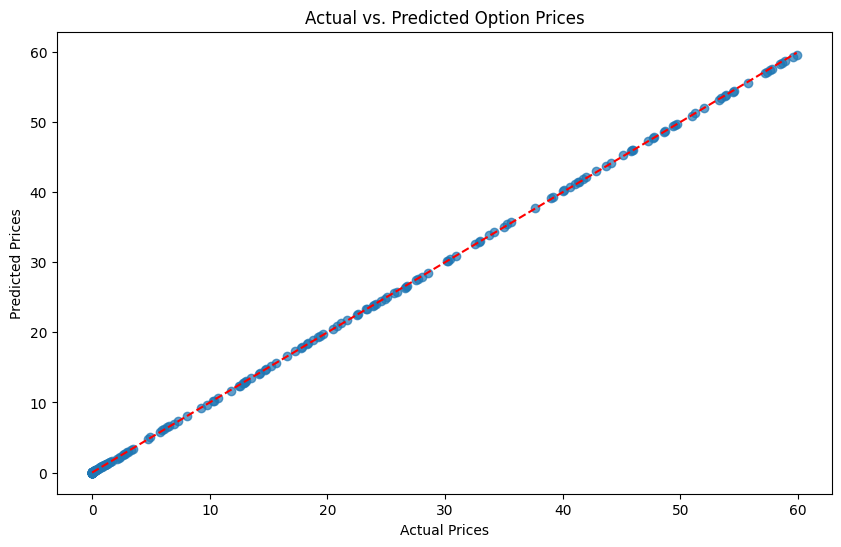

In [13]:
# Scatter plot of actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')  # Diagonal line for reference
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Option Prices')
plt.show()

While it may seem like the MLP "understands" the Black-Scholes formula, what's actually happening is that the network learns a mapping from inputs to outputs that closely mimics the formula's computation. This capability does not imply any inherent understanding or derivation of the formula by the network; rather, it's a testament to the MLP's ability to approximate complex functions through example-based learning.

Despite the accuracy in price prediction, what really matters to investors is the return on investment. Even if a model can predict the price of an option accurately, this information may not be directly correlated with or sufficient to determine whether the option will lead to a positive economic return. Investors might be more interested in models that can help them understand future investment performance in terms of return, rather than just in terms of price movements.

#### Exercise

Plot the MSE for different numbers of neurons and layers.